In [2]:
## 1. Setup & config

# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import mne
from scipy.stats import ttest_ind
import warnings

# Silence warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Move to directory
%cd /Users/diarmuidlenihan/Documents/eeg_proj

# Confirm w.d. and files
print("CWD now:", Path().resolve())
print("data/raw exists ->", Path("data/raw").exists())

# EEG configuration
RAW_DIR = Path("data/raw")   # Folder where your Origin_*.txt files are stored
SFREQ = 250.0                # Sampling frequency in Hz
CH_NAMES = [
    'Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2',
    'F7','F8','T7','T8','P7','P8','Fz','Cz','Pz','Oz',
    'FC1','FC2','CP1','CP2','FC5','FC6','CP5','CP6',
    'TP9','TP10','POz'
]

# Check file visiblity
files_check = sorted(RAW_DIR.glob("Origin_*.txt"))
print("Files found:", len(files_check))
for f in files_check[:5]:
    print(" -", f.name)

/Users/diarmuidlenihan/Documents/eeg_proj
CWD now: /Users/diarmuidlenihan/Documents/eeg_proj
data/raw exists -> True
Files found: 12
 - Origin_H1.txt
 - Origin_H2.txt
 - Origin_H3.txt
 - Origin_H4.txt
 - Origin_H5.txt


In [14]:
## 2. Helper functions

import pandas as pd
import numpy as np
from pathlib import Path

EEG_ONLY = [
    'Fp1','Fp2','F3','F4','C3','C4','P3','P4','O1','O2',
    'F7','F8','T7','T8','P7','P8','Fz','Cz','Pz','Oz',
    'FC1','FC2','CP1','CP2','FC5','FC6','CP5','CP6',
    'TP9','TP10','POz'
]  # 31 channels, no ECG

def load_txt_eeg_by_header(path, ch_names=EEG_ONLY):
    """
    Read the first non-empty line as a whitespace-separated header,
    map requested EEG channel names to their columns (ignoring extras like ECG),
    then read only those columns in that order.
    Returns (len(ch_names), n_times) float64 in native units (likely µV).
    """
    # 1) Read header tokens
    with open(path, "r", encoding="utf-8", errors="replace") as fh:
        header = None
        for line in fh:
            if line.strip():
                header = line.strip().split()
                break
    if header is None:
        raise ValueError(f"{Path(path).name}: empty file / no header")

    # 2) Build col index for EEG channels only (ignore ECG or any extras)
    idx_map = {}
    for ch in ch_names:
        if ch in header:
            idx_map[ch] = header.index(ch)
        else:
            raise ValueError(f"{Path(path).name}: missing channel in header: {ch}")
    usecols = [idx_map[ch] for ch in ch_names]

    # 3) Read data rows using whitespace, skip the header line, keep only EEG cols
    df = pd.read_csv(
        path,
        sep=r"\s+",
        engine="python",
        header=None,
        skiprows=1,
        usecols=usecols,
        names=ch_names
    )

    # 4) Ensure numeric, drop empty rows, interpolate small gaps, fill edges (DEPRECATED)
    #df = df.apply(pd.to_numeric, errors="coerce")
    #df = df.dropna(axis=0, how="all")
    #df = df.interpolate(method="linear", limit_direction="both")
    #df = df.fillna(method="bfill").fillna(method="ffill")
    #df = df.fillna(0.0)

    # 4) Ensure numeric, drop empty rows, interpolate small gaps, fill edges
    df = df.apply(pd.to_numeric, errors="coerce")  # coerce non-numeric to NaN
    df = df.dropna(axis=0, how="all")              # drop fully empty rows
    # Interpolate small gaps linearly along time
    df = df.interpolate(method="linear", limit_direction="both")
    # Fill any remaining NaNs by backfilling first, then forward filling
    df = df.bfill().ffill()
    # Final guard: if any stubborn NaNs remain, set them to 0
    df = df.fillna(0.0)

    X = df.to_numpy(dtype=float).T  # (n_ch, n_times)
    if X.shape[0] != len(ch_names):
        raise ValueError(f"{Path(path).name}: got {X.shape}, expected ({len(ch_names)}, n_times)")
    return X

In [15]:
## One file test

f = sorted(RAW_DIR.glob("Origin_*.txt"))[0]
X = load_txt_eeg_by_header(f, EEG_ONLY)
print("X stats:", X.shape, X.min(), X.max(), X.std())
info = mne.create_info(EEG_ONLY, SFREQ, ch_types="eeg")
raw  = mne.io.RawArray((X * (1e-6 if np.nanmax(np.abs(X)) > 1 else 1.0)), info, verbose=False)
raw.set_montage("standard_1020", on_missing='ignore')
raw.filter(1., 40., fir_design='firwin', verbose=False)
psd = raw.compute_psd(fmin=8., fmax=12., n_per_seg=500, n_overlap=250, window='hann', verbose=False)
print("alpha mean PSD:", float(psd.get_data().mean()))

/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


X stats: (31, 130000) -157.125153 211.843002 25.87051326238103
alpha mean PSD: 7.073817669958652e-12


In [13]:
## Inspecting raw values

f = sorted(RAW_DIR.glob("Origin_*.txt"))[0]
X = load_txt_eeg(f)

print("X shape:", X.shape)                 # expect (31, n_times)
print("dtype:", X.dtype)
print("min/max:", float(X.min()), float(X.max()))
print("mean/std:", float(X.mean()), float(X.std()))
print("first 3x10 values:\n", X[:3, :10])

X shape: (31, 130000)
dtype: float64
min/max: nan nan
mean/std: nan nan
first 3x10 values:
 [[2.4671412e-05           nan           nan           nan 3.1240946e-05
  3.4126396e-05 3.6207893e-05 3.6516834e-05 3.5285347e-05           nan]
 [          nan 7.6634440e-06 8.0547310e-06 8.8656060e-06           nan
  1.0259102e-05           nan           nan 9.6067550e-06           nan]
 [          nan           nan           nan           nan           nan
            nan           nan           nan           nan           nan]]


In [16]:
## 3. File processing

# Identify and sort all EEG text files
files = sorted(RAW_DIR.glob("Origin_*.txt"))
print("Processing", len(files), "files...")

rows = []
for f in files:
    group = "HC" if "_H" in f.stem else "PTSD"
    subj  = f.stem.replace("Origin_", "")

    # 1) Load EEG ONLY (drops ECG column)
    X = load_txt_eeg_by_header(f, EEG_ONLY)          # (31, n_times)

    # quick diagnostics
    print(f"{f.name:16s} shape={X.shape} min={X.min():.3f} max={X.max():.3f} std={X.std():.3f}")

    # 2) Build Raw (convert µV→V for MNE if magnitudes look like µV)
    scale = 1e-6 if np.nanmax(np.abs(X)) > 1 else 1.0
    info  = mne.create_info(EEG_ONLY, SFREQ, ch_types="eeg")
    raw   = mne.io.RawArray(X * scale, info, verbose=False)
    raw.set_montage("standard_1020", on_missing='ignore')

    # 3) Bandpass 1–40 Hz (FIR)
    raw.filter(1., 40., fir_design='firwin', verbose=False)

    # 4) PSD (MNE ≥1.10)
    psd_alpha = raw.compute_psd(fmin=8.,  fmax=12., n_per_seg=500, n_overlap=250, window='hann', verbose=False)
    psd_beta  = raw.compute_psd(fmin=13., fmax=30., n_per_seg=500, n_overlap=250, window='hann', verbose=False)
    alpha_power = float(psd_alpha.get_data().mean(axis=1).mean())
    beta_power  = float(psd_beta.get_data().mean(axis=1).mean())

    rows.append({"subject": subj, "group": group,
                 "alpha_power": alpha_power, "beta_power": beta_power})

df = pd.DataFrame(rows).sort_values(["group","subject"])
display(df)

Path("outputs/results").mkdir(parents=True, exist_ok=True)
df.to_csv("outputs/results/band_power_2018.csv", index=False)
print("Saved to outputs/results/band_power_2018.csv")

Processing 12 files...


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_H1.txt    shape=(31, 130000) min=-157.125 max=211.843 std=25.871


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_H2.txt    shape=(31, 130000) min=-163.571 max=187.455 std=23.558


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_H3.txt    shape=(31, 130000) min=-163.921 max=238.680 std=27.692


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_H4.txt    shape=(31, 130000) min=-620.297 max=691.529 std=30.401


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_H5.txt    shape=(31, 130000) min=-389.500 max=840.097 std=36.052


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_H6.txt    shape=(31, 130000) min=-311.047 max=343.714 std=25.958


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_P1.txt    shape=(31, 130000) min=-187.199 max=136.851 std=22.355


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_P2.txt    shape=(31, 130000) min=-208.705 max=276.644 std=21.986


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_P3.txt    shape=(31, 130000) min=-261.669 max=334.631 std=26.820


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_P4.txt    shape=(31, 130000) min=-302.971 max=190.725 std=27.014


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_P5.txt    shape=(31, 130000) min=-224.752 max=389.554 std=22.213


/var/folders/p1/p7d2kznj2ngb8ygpywx3dw800000gn/T/ipykernel_51896/346771805.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


Origin_P6.txt    shape=(31, 130000) min=-191.494 max=286.629 std=23.027


,subject,group,alpha_power,beta_power
0,H1,HC,7.073818e-12,2.135223e-13
1,H2,HC,1.888803e-12,7.738904e-14
2,H3,HC,1.813905e-11,2.790128e-13
3,H4,HC,3.773758e-12,1.629450e-13
4,H5,HC,1.005619e-11,3.890985e-13
5,H6,HC,7.425730e-12,3.370606e-13
6,P1,PTSD,3.036619e-12,2.368091e-13
7,P2,PTSD,2.491213e-12,1.512499e-13
8,P3,PTSD,1.026517e-12,8.122324e-14
9,P4,PTSD,9.784338e-13,7.183786e-14


Saved to outputs/results/band_power_2018.csv


alpha_power: t=-2.19, p=0.0691
beta_power: t=-1.94, p=0.0882


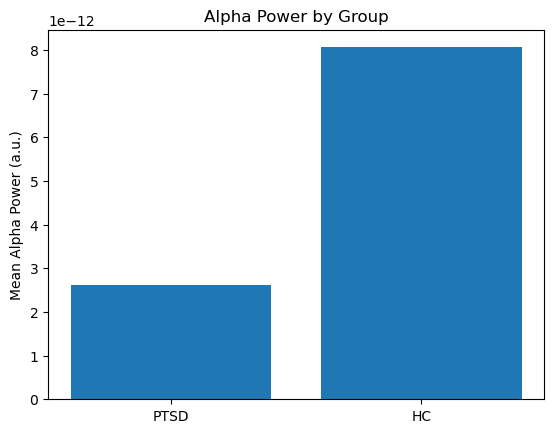

In [17]:
## 4. Stats & plots

# T-tests for group differences
for band in ["alpha_power", "beta_power"]:
    a = df[df.group=="PTSD"][band]
    b = df[df.group=="HC"][band]
    t, p = ttest_ind(a, b, equal_var=False)
    print(f"{band}: t={t:.2f}, p={p:.4f}")

# Simple bar plot
plt.bar(["PTSD","HC"], [
    df[df.group=="PTSD"]["alpha_power"].mean(),
    df[df.group=="HC"]["alpha_power"].mean()
])
plt.ylabel("Mean Alpha Power (a.u.)")
plt.title("Alpha Power by Group")
plt.show()

In [2]:
import mne, scipy
print("MNE:", mne.__version__)
print("SciPy:", scipy.__version__)

MNE: 0.23.4
SciPy: 1.16.1


In [8]:
print("n_times:", raw.n_times, "sfreq:", SFREQ)

n_times: 130000 sfreq: 250.0


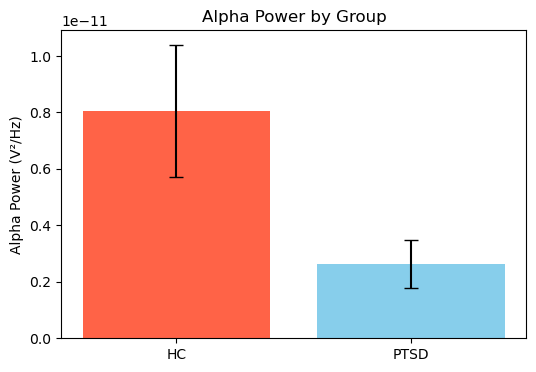

In [18]:
## 4. Stats & plots

import matplotlib.pyplot as plt
import numpy as np

# Compute group means and standard errors
means = df.groupby("group")["alpha_power"].mean()
errors = df.groupby("group")["alpha_power"].sem()  # standard error

plt.figure(figsize=(6,4))
plt.bar(means.index, means.values, yerr=errors.values, capsize=5, color=["tomato", "skyblue"])
plt.ylabel("Alpha Power (V²/Hz)")
plt.title("Alpha Power by Group")
plt.show()